# Static Scattering + Rotations with SO3 sampling + Alignment (ADMs), testing with N2 ADMs
22/01/25

Testing with N2 and other molecules.


17/01/25

As 15/01/25 case, but test with N2O plus test ADMs (use N2 case).

15/01/25, PH

Adding full treatment of alignment from ADMs (inc. coherence).

- For previous work, see http://fock.femtolab.ca:9988/lab/tree/share/projects/sacla/no2_scattering_Oct_2024/modelling/scattering_rotations_sampling_091224.ipynb
- For alignment dev and tests, see http://fock.femtolab.ca:9988/lab/tree/share/code-share/jupyter-shared/numerical_integration_sampling_2024/rotations_SO3/coherent_rotations_150125.ipynb

09/12/24, PH

Adapted from Ian Gabalski's scatting codes, adding:

- molecule rotations
    - In this version use SciPy for rotations instead of RDkit
- sampling over rotational distributions
    - Use OpenQuad library, quickStart: https://qucontrol.github.io/openquad/latest/using/quickstart.html#quickstart

Functions quick and dirty in `scattering_funcs.py`, just load here then work from there.

For initial demo see http://fock.femtolab.ca:9988/lab/tree/share/projects/sacla/no2_scattering_Oct_2024/modelling/scattering_rotations_061224.ipynb

For dev notes see http://fock.femtolab.ca:9988/lab/tree/share/projects/sacla/no2_scattering_Oct_2024/modelling/Static%20Scattering%20-%20with%20anisotropy%20-%20PH_031224.ipynb

STATUS: basically seems to be working as expected!

In [1]:
%run scattering_funcs.py

*** Setting some constants and loading form factor data form file.
*** Loading HV plotters...


*** Loading epsman and related modules for molecule handling.
If this fails, you may need epsman, `pip install -e epsman --user` (and `git clone -b restructure160221 https://github.com/phockett/epsman.git` to get the source), and maybe also `pip install fabric pygamess rdkit --user` for dependencies.
*** py3Dmol not available, 3D plots with RDkit will not be available.


In [2]:
# May need this for MPL backend
%matplotlib inline

## Import molecule with epsman/rdkit routines

Note for multiple rotations case can also just work directly from Numpy (x,y,z) coord array, but use rdkit here for plotters etc.

In [3]:
# Note this is currently set in the script.
# xyzPath

Set name = N2
Set smiles = None
Set molFile = None
Set pd = None
Set xyz = None
Set molOverride = None
Set job = None
Set sym = C1
Set atomList = None
Set precision = 6
Set atomsDict = {}
Set refDict = {}
Set atomsHist = {}
*** Updating coords (Pandas version).


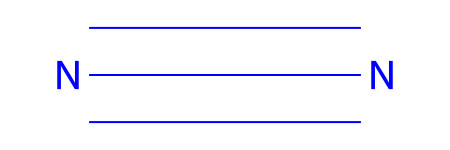

,Ind,Species,Atomic Num.,x,y,z
0,0,N,7,-0.556,0.0,0.0
1,1,N,7,0.556,0.0,0.0


In [3]:
# molecule='SF6'

# SF6 = loadMol(molecule, xyzPath)

#**** Use downloader...  NOPE, it's rubbish.
molecule = 'N2'
# molecule = 'nitric oxide'
# molecule = 'Nitrogen Dioxide'
mol = ESgamess(searchName = molecule)
# mol.molFromPubChem(recordType='2d')  # ANNOYING - for NO2 2D only, and only full name works? Pubchem page: https://pubchem.ncbi.nlm.nih.gov/compound/Nitrogen-dioxide
#                                      # ALSO THIS MESSES UP SOME OTHER CLASS CREATION STUFF. FIX THIS PLEASE

#*** Use file (downloaded above
# molecule = 'NO2'
# mol = ESgamess(molFile = f'{molecule}.SDF')

In [29]:
# Set orientation to z-axis if desired (or set other arb rotation)
mol.rotateFrame()

*** Updating coords (Pandas version).
*** Set frame rotations, new coord table:


,Ind,Species,Atomic Num.,x,y,z
0,0,N,7,0.0,0.0,-0.556
1,1,N,7,0.0,0.0,0.556


In [5]:
# mol.plot2D()

## Sampling over SO3

In [30]:
from openquad import SO3

def sampleSO3(degree=3,size=3):
    """
    Sample over SO3 using OpenQuad
    
    Use recommended method in Quickstart, with passing of degree and size.
    
    """
    
    quad = SO3([
        ('LebedevLaikov', dict(degree=degree)),
        ('Trapezoid', dict(size=size)),
        ])
    
    print(f"Generated samples on SO3: {quad.points.shape}.")
          
    return quad

In [31]:
quadSample = sampleSO3()

Generated samples on SO3: (3, 18).


## Rotations with SciPy

In [32]:
from scipy.spatial.transform import Rotation as R

def rotateXYZ(xyz, eulerAngles=[0,0,0]):
    """
    Rotate coord array.
    
    Uses scipy.spatial.transform.Rotation
    
    Pass np.array of [x,y,z] coords and set of Euler angles (radians). 
    
    
    """
    
    r = R.from_euler("ZYX", eulerAngles)  # intrinsic - THIS CASE MATCHES RDKIT METHOD
    # r2 = R.from_euler("zyx", [0, np.pi/2, np.pi/3])  # extrinsic
    
    xyzR = r.apply(xyz)
    
    return xyzR


def genMolRotations(mol, samples):
    """
    Generate all molecular rotations for sample array.
    
    mol can be [species,x,y,z] coord array, or ESgamess class object.
    
    Returns dictionary of rotated coords and corresponding Euler angles.
    """
    
    # Check input type, allow for class not loaded case
    xyzMol = mol
    try:
        if isinstance(mol, ESgamess):
            if not 'ref' in mol.refDict.keys():
                mol.setRef()
                
            xyzMol = mol.refDict['ref']['pd'][['Species','x','y','z']].to_numpy()
    except:
        pass
    
    # Generate rotations
    geoms = {}
    for n,eulers in enumerate(samples.angles.T):
        geoms[n] = {'xyz':np.c_[xyzMol[:,0],rotateXYZ(xyzMol[:,1:].astype(float),eulers)],
                   'eulers':eulers,
                   'w':samples.weights[n]}
        
    # geom['ref'] = 
        
    return geoms
    
    # return rotateXYZ(xyz,samples.angles)

In [33]:
geomsDict = genMolRotations(mol,quadSample)

## Compute scattering with spatial sampling

In [34]:
def multScatter(geomsDict, QQ):
    """
    Compute scattering for each [x,y,z] in geomDict.
    """
    
    scatSum = np.zeros(QQ.shape[0:-1]).astype(complex)
    
    scatDict = {}
    for k,v in geomsDict.items():
        
        fQ = scatteringPairs(v['xyz'],QQ)
        
        scatDict[k] = {'f':fQ,
                       'w':v['w']}
        
        scatSum += v['w'] * fQ
        
    # Push to Xarray?
    
    # Direct summation
    
    return scatSum, scatDict
    
    
        
    

In [35]:
scatSum, scatDict = multScatter(geomsDict,QQ)

/home/jovyan/share/projects/sacla/no2_scattering_Oct_2024/modelling/scattering_funcs.py:252: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(QQx,QQy,ffplot, norm=norm)


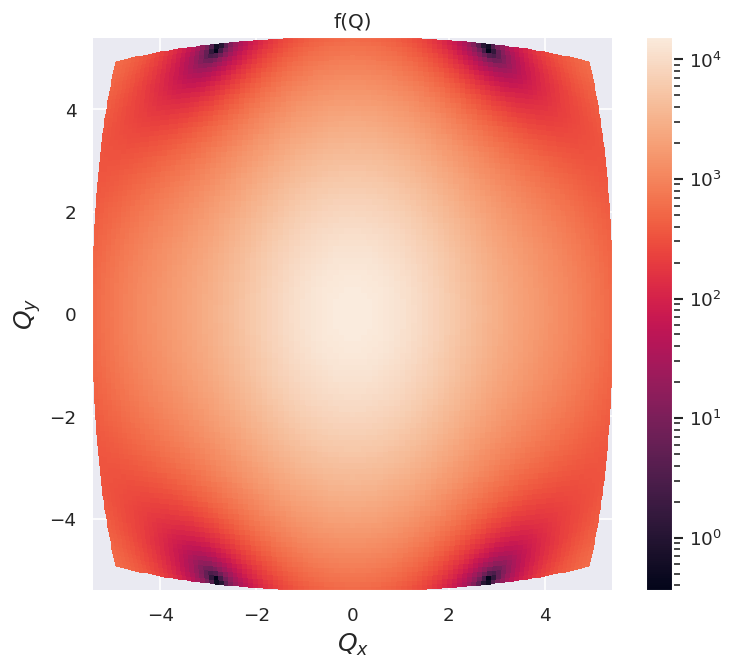

In [36]:
plotter = 'mpl'
plotff2(QQ,scatSum, backend=plotter, norm='log')

### Scattering with alignment - basic case

Add angular weightings to simulate aligned case, here just set $\cos^2(\theta)$ weighting.

Generated samples on SO3: (3, 962).


/home/jovyan/share/projects/sacla/no2_scattering_Oct_2024/modelling/scattering_funcs.py:252: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(QQx,QQy,ffplot, norm=norm)


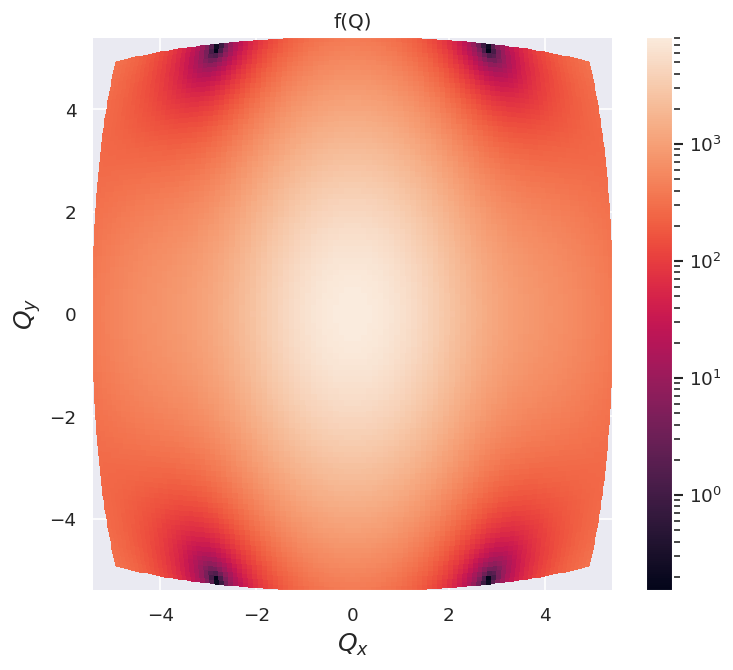

In [37]:
# Quick test for cos^2 dist...

# Update sampling if desired
n=13
quadSampleAlign = sampleSO3(degree=n,size=n)
geomsDictAlign = genMolRotations(mol,quadSample)
scatSumAlign, scatDictAlign = multScatter(geomsDictAlign,QQ)

# Set to new dict
alignDict = scatDictAlign.copy()
scatSumAligned = np.zeros(QQ.shape[0:-1]).astype(complex)

for k,v in alignDict.items():
    theta = geomsDict[k]['eulers'][0]
    scatSumAligned += v['w'] * v['f'] * 0.8*np.cos(theta)**2   # Add higher order terms... * 0.3*np.cos(theta)**4
    
plotff2(QQ,scatSumAligned, backend=plotter, norm='log')

In [38]:
def diffPlot(S1, S2, norm = True, plot = True):
    """
    Compute diffs and plot.
    
    Normalise if norm=True
    """
    if norm:
        S1 = S1/S1.sum()
        S2 = S2/S2.sum()
    
    diff = S1-S2
    
    if plot:
        plotff2(QQ,diff, backend=plotter)
    
    return diff

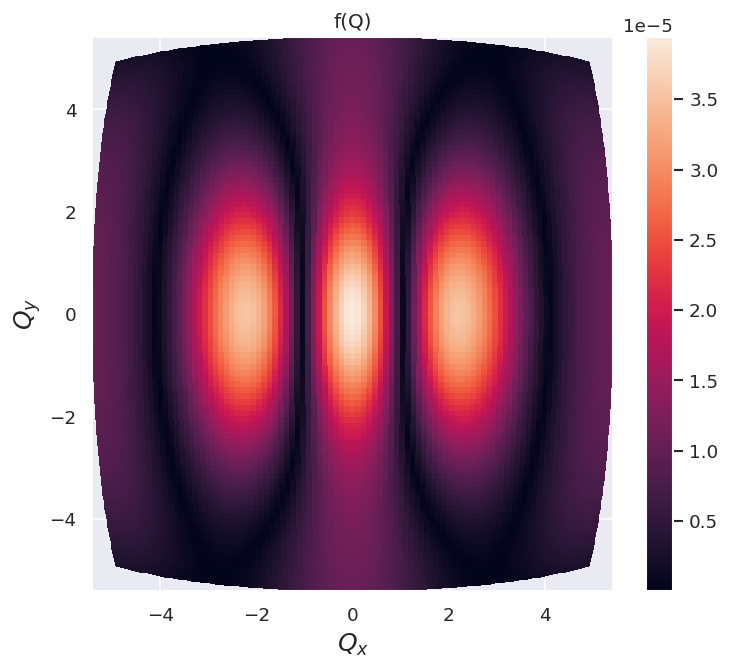

In [39]:
# Diff...
diff = diffPlot(scatSumAligned, scatSum, norm=True)

### Scattering with alignment - rotational wavepacket and ADMs case

TODO: confirm consistent axis defns. relative to input molecule and scattering plane.

Following Pabst et. al., who give (as expected) the result for the scattering x-section $S(Q)$ from an aligned ensemble as:

\begin{equation}
\begin{split}
S \left(\right. Q \left.\right) & =  \int_{- \infty}^{\infty} dt \textrm{ } j_{X} \left(\right. t \left.\right) \iiint d \phi \textrm{ } d \theta \textrm{ } d \chi sin \theta \\ & \times  \rho \left(\right. \phi , \theta , \chi ; t \left.\right) \left|\right. F_{mol} \left(\right. Q , \phi , \theta , \chi \left.\right) \left|\right. ^{2}
\end{split}\label{eqn33}
\end{equation}

Where the density matrix is determined from the rotational wavepacket:

\begin{equation}
\rho \left(\right. \phi , \theta , \chi ; t \left.\right)  =  \sum_{J \tau M} w_{J \tau} \left|\right. \langle \phi , \theta , \chi \left|\right. \Psi_{J \tau M} \left(\right. t \left.\right) \rangle \left|\right. ^{2}
\label{eqn35}
\end{equation}

We can also (as usual) express this density matrix as the (spatial) axis distribution moments (ADMs), with Wigner D functions as the angular basis:

\begin{equation}
\rho \left(\right. \phi , \theta , \chi ; t \left.\right)  = \sum_{K,Q,S}A^{K}_{Q,S}(t)D^{K}_{Q,S}(\phi , \theta , \chi)
\end{equation}

In this case this would be something like (to be verified - need to check some aspect of $\rho \left(\right. \phi , \theta , \chi ; t \left.\right)$ derivation), following the notation as above:

\begin{equation}
\begin{split}
S \left(\right. Q \left.\right) & =  \int_{- \infty}^{\infty} dt \textrm{ } j_{X} ( t ) 
\iiint d \phi  d \theta \textrm{ } d \chi sin \theta \\ & \times  \sum_{K,Q,S}A^{K}_{Q,S}(t)D^{K}_{Q,S}(\phi , \theta , \chi)  F_{mol} ( Q , \phi , \theta , \chi ) F_{mol}^{*} ( Q , \phi , \theta , \chi ) 
\end{split}\label{eqn33-coherent-ADM}
\end{equation}

In the numerics below this is implemented aside from the pulse $j_{X}(t)$ and temporal integration (i.e. equivalent to an impulsive assumption on the rotational timescale).

Ref: Stefan Pabst, Phay J. Ho, and Robin Santra. “Computational Studies of X-Ray Scattering from
Three-Dimensionally-Aligned Asymmetric-Top Molecules”. In: Physical Review A 81.4 (Apr. 29,
2010), p. 043425. doi: 10.1103/PhysRevA.81.043425. url: https://link.aps.org/doi/10.
1103/PhysRevA.81.043425 

In [40]:
# Load N2 case
# Code from QM3 book
# TODO: redo with ep.ADM class, currently in progress/dev elsewhere.

from pathlib import Path
from scipy.io import loadmat
import epsproc as ep

admFileName = 'N2_ADM_VM_290816.mat'
# epDemoDataPath = Path(ep.__path__[0]).parent/'data'
epDemoDataPath = '/home/jovyan/share/code-share/github-share/ePSproc/data'
ADMdataFile = Path(epDemoDataPath, 'alignment', admFileName)

ADMraw = loadmat(ADMdataFile)
tOffset = -3.76
ADMraw['time'] = ADMraw['time'] + tOffset

ADMxr = ep.setADMs(ADMs = ADMraw['ADM'], t=ADMraw['time'].squeeze(), 
                  KQSLabels = ADMraw['ADMlist'], addS = True)

# Quick plot
ADMxr.unstack().real.hvplot(x='t').overlay(['K','Q','S'])

:NdOverlay   [S,Q,K]
   :Curve   [t]   (ADM)

In [41]:
# Case using ADMs and Wigner D expansions
# From http://fock.femtolab.ca:9988/lab/tree/share/code-share/jupyter-shared/numerical_integration_sampling_2024/rotations_SO3/coherent_rotations_150125.ipynb

# import epsproc as ep
import xarray as xr

# Set alignment terms (ADMs), expressed as [K,Q,S,t0,t1...]
# ADMs = ep.setADMs(ADMs = [[0,0,0,1,1,1,1],
#                           [2,0,0,0,0.5,0.8,0.8],
#                           [4,0,0,0,0,0,0.8]])

# ADMs from full calc with subselection by range & step size.
trange = [2,10]  # [2,6]
ADMs = ADMxr.where(ADMxr.t>trange[0]).where(ADMxr.t<trange[1]).dropna('t').isel(t=slice(None,None,10))

# Generate Wigner D functions as required - all Eulers and K,Q,S
wD = ep.wDcalc(Lrange=ADMs.ADM.K.values, eAngs=quadSample.angles.T, dlist=['K', 'Q', 'S'])

# Expansion p(Omega,t)... 
# Currently need to unstack for non-matching multi-index names?
# Should check code elsewhere for other options here.
pt = ADMs.unstack('ADM') * wD.unstack('QN')

# For full sampling sum over K,Q,S and multiply by quadSample.weights
# ptWeights = pt.sum(['K','Q','S']) * quadSample.weights 
# Weights now in loop below, so only set sum
ptSum = pt.sum(['K','Q','S'])

# Compute scattering
# As above, but add loop over t for quick hacky mod!
# Note this assumes t is first dim of array, and index == keys in alignDict (value per set of Eulers)
scatSumt = np.zeros([*QQ.shape[0:-1],ptSum.shape[0]]).astype(complex)
for n,tWeight in enumerate(ptSum):
    alignDict = scatDict.copy()
    scatSumAligned = np.zeros(QQ.shape[0:-1]).astype(complex)

    for k,v in alignDict.items():
        theta = geomsDict[k]['eulers'][0]
        scatSumAligned += v['w'] * v['f'] * tWeight.values[k]

    # plotff2(QQ,scatSumAligned, backend=plotter, norm='log')
    
    scatSumt[:,:,n] = scatSumAligned.copy()
    
# Set final results to XR
# NOTE - probably a neater way to do this!
# TODO - push to existing VMI plotter

# scatXR = xr.DataArray(scatSumt, {'Qx':QQ[0,:],'Qy':QQ[:,0],'t':tWeight.t)
scatXR = xr.DataArray(scatSumt, dims=('Qx','Qy','t'), 
                      coords={'Qx':QQ[0,:,0].flatten(),'Qy':QQ[:,0,0].flatten(),'t':ptSum.t})
# scatXR

In [42]:
scatXR.t

<xarray.DataArray 't' (t: 41)>
array([2.010431, 2.207218, 2.404005, 2.600792, 2.797579, 2.994365, 3.191152,
       3.387939, 3.584726, 3.781513, 3.978299, 4.175086, 4.371873, 4.56866 ,
       4.765447, 4.962233, 5.15902 , 5.355807, 5.552594, 5.749381, 5.946167,
       6.142954, 6.339741, 6.536528, 6.733315, 6.930101, 7.126888, 7.323675,
       7.520462, 7.717249, 7.914035, 8.110822, 8.307609, 8.504396, 8.701183,
       8.897969, 9.094756, 9.291543, 9.48833 , 9.685117, 9.881903])
Coordinates:
  * t        (t) float64 2.01 2.207 2.404 2.601 ... 9.292 9.488 9.685 9.882
Attributes:
    units:    ps

In [43]:
# HV plot from XR
# import hvplot.xarray

# Plot raw imgs vs. t
scatXR.real.hvplot.image(x='Qx',y='Qy')

:DynamicMap   [t]
   :Image   [Qx,Qy]   (value)

In [44]:
# Quick diffs
# scatXR.diff('t').real.hvplot.image(x='Qx',y='Qy')

# Vs. isotropic case
(scatXR - scatXR.isel(t=0)).where(scatXR.t>0, drop=True).real.hvplot.image(x='Qx',y='Qy')

:DynamicMap   [t]
   :Image   [Qx,Qy]   (value)

Quick tests, N2O using demo N2 two-pulse ADMs.

- Testing 2 - 6ps range, 21 t-points
    - Can definitely see effects of anti-alignment in raw plots.
    - VERY clear in diff plots vs. 1st t-point, NICE!!!

In [ ]:
break

## Benchmarks

- Timings
- Comparison with isotropic case (analytic).

### Convergence (to isotropic case)

Basics look good, need to add log plotting to plotff2!

UPDATE: add log plotting. Looks good aside from overall intensity/norm difference.

In [ ]:
def isotropic_scattering(xyz,QQ):
    output = np.zeros(QQ.shape[:-1],dtype=float)
    for atom in xyz:
        output += np.abs(load_form_fact(atom[0])(QQ))**2
    for i in range(len(xyz)):
        for j in range(i+1,len(xyz)):
            atom1 = xyz[i][0]
            atom2 = xyz[j][0]
            xyz1 = np.array(xyz[i][1:])
            xyz2 = np.array(xyz[j][1:])
            ff1 = load_form_fact(atom1)
            ff2 = load_form_fact(atom2)
            r_ij = norm(xyz1-xyz2)
            output += 2*np.abs(ff1(QQ)*ff2(QQ))*np.sinc(1/np.pi*norm(QQ,axis=-1)*r_ij)
    return output

xyzMol = mol.refDict['ref']['pd'][['Species','x','y','z']].to_numpy()
QQx, QQy, QQz = QQ[:,:,0], QQ[:,:,1], QQ[:,:,2]

isotropic_scattering_2d = isotropic_scattering(xyzMol,QQ)
plt.figure(figsize=(7,6))
plt.pcolormesh(QQx,QQy,np.abs(isotropic_scattering_2d),
              norm=None)
plt.colorbar()
plt.xlabel(r'$Q_x$',fontsize=15)
plt.ylabel(r'$Q_y$',fontsize=15)
plt.title('Isotropic ensemble (%s)' % molecule, fontsize=20)
plt.show()

In [ ]:
diff = diffPlot(isotropic_scattering_2d, scatSum, norm=True)
(diff**2).sum()

In [ ]:
# Test convergence vs. sampling

# Configure sampling
# This is a bit lazy - assume some terms already defined in workspace
def setupInputs(n):
    quadSample = sampleSO3(degree=n,size=n)
    geomsDict = genMolRotations(mol,quadSample)
    
    return geomsDict, QQ

# Generate data per sample
def computeDiffs(n):

    geomsDict,QQ = setupInputs(n)
    
    scatSum, scatDict = multScatter(geomsDict,QQ)
    
    diff = diffPlot(isotropic_scattering_2d, scatSum, norm=True, plot = False)
    
    return diff, scatSum, scatDict
    
# 
def convergenceTests(nrange = range(3, 5, 2)):
    cDict = {}
    cSums = []
    
    for n in nrange:
        print(f"*** Running n={n}...")
        diff, scatSum, scatDict = computeDiffs(n)
        diffSum = (diff**2).sum()
        cDict[n] = {'diff':diff, 'diffSum':diffSum,
                    'scatSum':scatSum, 'scatDict':scatDict}
        cSums.append([n, diffSum])

    
    return cDict, cSums

In [ ]:
cDict, cSums = convergenceTests(range(3,17,2))

In [ ]:
# pd.DataFrame.from_dict(cDict, orient='index')
df = pd.DataFrame(cSums, columns=['n','diff']).set_index('n')
df

In [ ]:
# Check sum(diff**2) for convergence...
df.pipe(np.abs).hvplot(x='n')

In [ ]:
# Check specific cases...
n=9
plotff2(QQ, cDict[n]['diff'], backend=plotter)

In [ ]:
n=13
plotff2(QQ, cDict[n]['diff'], backend=plotter)

In [ ]:
plotff2(QQ, cDict[n]['scatSum'], backend=plotter, norm='log')

In [ ]:
plotff2(QQ, isotropic_scattering_2d, backend=plotter, norm='log')

### Timings

In [ ]:
# Benchmarks with xyzpy
# https://xyzpy.readthedocs.io/en/latest/utilities.html
import xyzpy

# Set test kernels
kernels = [
    multScatter,
]

# Set benchmarker object
benchmarker = xyzpy.Benchmarker(
    kernels,
#     setup=setQNs,
    setup=lambda n: setupInputs(n),  # Use lambda fn to ensure correct input here, see also Perfplot https://github.com/nschloe/perfplot
    benchmark_opts={'min_t': 0.01, 'starmap': True}   # Use starmap = true to pass all args, foo(*setup(n))
)

# Run benchmarks for all kernels
nrange = range(3, 17, 2)
benchmarker.run(nrange, verbosity=2)



In [ ]:
benchmarker.ilineplot()

## Versions

In [ ]:
import scooby
scooby.Report(additional=['xarray', 'jupyter'])